In [67]:
import sys
sys.path.append("code")

# %load_ext autoreload

In [68]:
from itertools import product

import matplotlib
import matplotlib.pyplot as plt
import spiceypy as spice
import pandas as pd
import numpy as np
import seaborn as sb
from scipy.special import lpmv
import pyshtools as pysh
from pyshtools.legendre import legendre_lm
from skimage.io import imread
from skimage.filters.rank import mean
from skimage.morphology import square
from skimage.measure import block_reduce
from skimage.metrics import normalized_root_mse

In [69]:
from plotting import format_plot, save_plot
from spice_tools import as_et

# Reference frames

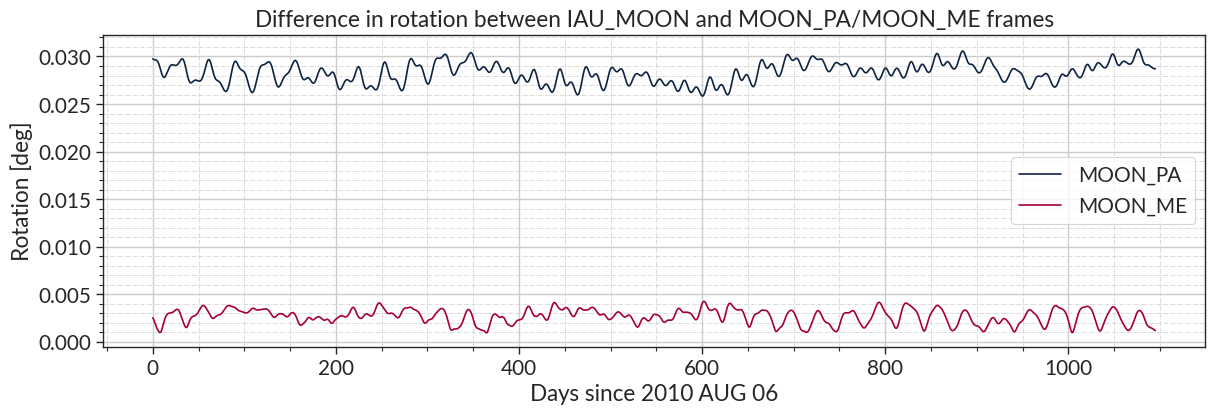

In [70]:
def plot_moon_frame_difference():
    def quat_to_deg(q):
        ang_rad = 2 * np.arctan2(np.linalg.norm(q[1:]), q[0])
        return np.degrees(ang_rad)

    plt.subplots(figsize=(12, 4))

    t_start = as_et("2010 AUG 06")
    n_years = 3
    t = np.linspace(t_start, t_start + n_years * 365 * 24 * 3600, 1000)

    plt.plot(
        (t - t_start) / (3600 * 24),
        np.vectorize(lambda tt: quat_to_deg(spice.m2q(spice.pxform("MOON_PA", "IAU_MOON", tt))))(t),
        label="MOON_PA")
    plt.plot(
        (t - t_start) / (3600 * 24),
        np.vectorize(lambda tt: quat_to_deg(spice.m2q(spice.pxform("MOON_ME", "IAU_MOON", tt))))(t),
        label="MOON_ME")

    plt.xlabel("Days since 2010 AUG 06")
    plt.ylabel("Rotation [deg]")
    plt.title(f"Difference in rotation between IAU_MOON and MOON_PA/MOON_ME frames")
    plt.legend()

    format_plot()

plot_moon_frame_difference()

# Angle-based thermal radiation

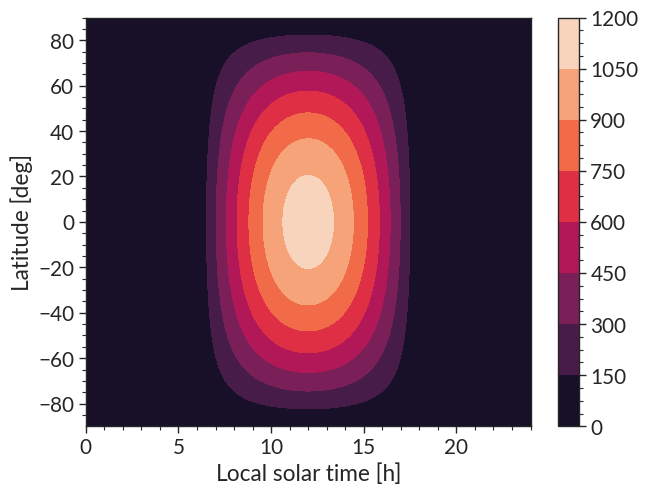

In [71]:
def thermal_radiation(polar, azimuth):
        subsolar = np.array([1, 0, 0])
        normal = np.array([
            np.cos(azimuth) * np.sin(polar),
            np.sin(azimuth) * np.sin(polar),
            np.cos(polar)
        ])
        cosphi = max(0, subsolar @ normal)
        
        sigma = 5.670374419e-8
        T = max(375 * cosphi**(1/4), 100)
        return sigma * T**4

def plot_thermal_lemoine():
    # Recreate Fig. 5 from Lemoine 2013
    polarlist = np.linspace(0, 1, 100) * np.pi
    azimuthlist = np.linspace(-1, 1, 100) * np.pi
    polars, azimuths = np.meshgrid(polarlist, azimuthlist)
    
    exitances = np.vectorize(thermal_radiation)(polars, azimuths)
    plt.contourf((azimuths / np.pi + 1) * 12, 90 - np.degrees(polars), exitances)
    plt.colorbar()
    plt.xlabel("Local solar time [h]")
    plt.ylabel("Latitude [deg]")
    
    format_plot()
    
plot_thermal_lemoine()

In [72]:
thermal_radiation(np.pi / 2, 0)

1121.3386912573242

Maximum is 1121 W/m^2, which agrees with Lemoine (2013).

In [73]:
thermal_radiation(np.pi / 2, np.pi)

5.670374419

Minimum is 5.7 W/m^2.

# SH albedo distribution

$$
a = \sum_{l=0}^\infty \sum_{m=0}^l ...
$$
* $n=l$: degree
* $m$: order

In [74]:
def read_coeffs():
   # DLAM-1 coefficients are in GEODYN format
   # See https://earth.gsfc.nasa.gov/sites/default/files/volume3.pdf
   with open("files/DLAM-1.txt") as f:
       lines = f.readlines()
   lines = [line[8:-1] for line in lines[5:]]
   
   cos_coeffs = np.zeros((16, 16))
   sin_coeffs = np.zeros((16, 16))

   for line in lines:
      l = int(line[:2])
      m = int(line[2:4])
      
      cos_coeffs[l, m] = float(line[20:36].replace("D", "E"))
      sin_coeffs[l, m] = float(line[37:].replace("D", "E"))
   
   # sin_coeffs, cos_coeffs = cos_coeffs, sin_coeffs
   return cos_coeffs, sin_coeffs

cos_coeffs, sin_coeffs = read_coeffs()

In [75]:
# with np.printoptions(precision=1, linewidth=1000):
#     print("rows = degree, cols = order")
#     print(cos_coeffs)

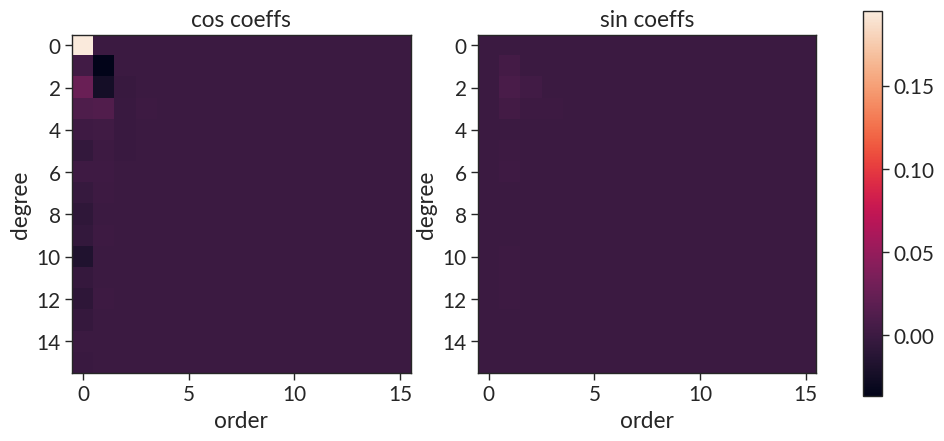

In [76]:
def plot_coeffs():
    vmin = min(cos_coeffs.min(), sin_coeffs.min())
    vmax = max(cos_coeffs.max(), sin_coeffs.max())

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.imshow(cos_coeffs, vmin=vmin, vmax=vmax)
    ax1.set_title("cos coeffs")
    ax1.set_xlabel("order")
    ax1.set_ylabel("degree")

    im = ax2.imshow(sin_coeffs, vmin=vmin, vmax=vmax)
    ax2.set_title("sin coeffs")
    ax2.set_xlabel("order")
    ax2.set_ylabel("degree")

    plt.colorbar(im, ax=[ax1, ax2])

plot_coeffs()

In [77]:
def dlam1(lat, lon, degrees=True):
   if degrees:
      lat = np.radians(lat)
      lon = np.radians(lon)
   sin_lat = np.sin(lat)

   a = 0
   for l in range(0, 16):
      for m in range(0, l+1):
         # (-1)^m to remove Condon-Shortley phase of lpmv
         Pnm = (-1)**m * lpmv(m, l, sin_lat)
         a += (
            cos_coeffs[l, m] * np.cos(m * lon) + sin_coeffs[l, m] * np.sin(m * lon)
         ) * Pnm
   return a

dlam1(60, 20)

0.24454921785705433

In [78]:
def generate_albedo_map_manual():
   step = 1
   lats = range(-90, 90, step)
   lons = range(-180, 180, step)

   albedo_map = np.empty((180, 360))
   for lat, lon in product(lats, lons):
      albedo_map[lat + 90, lon + 180] = dlam1(lat, lon)

   # Flip latitude
   albedo_map = np.flipud(albedo_map[::step, ::step])

   return albedo_map

albedo_map_manual = generate_albedo_map_manual()

In [79]:
def plot_albedo_map(albedo_map):
    fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
    ax.set_title(f"Albedo map (min = {albedo_map.min():.2f}, max = {albedo_map.max():.2f})")

    im = ax.imshow(albedo_map, cmap="gray", vmin=0, vmax=1)
    plt.colorbar(im)
    ax.set_yticks(range(0, 181, 30), range(90, -91, -30))
    ax.set_xlabel("Longitude [°]")
    ax.set_ylabel("Latitude [°]")
    ax.set_xticks(range(0, 361, 30), range(-180, 181, 30))

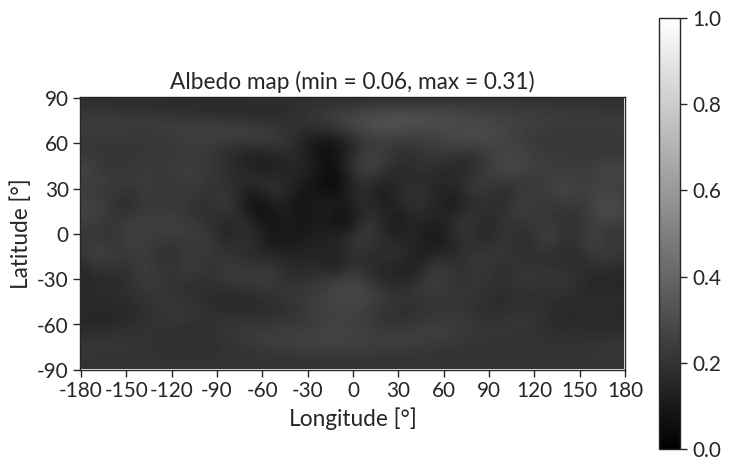

In [80]:
plot_albedo_map(albedo_map_manual)

In [81]:
def generate_albedo_map_shtools():
    sh = pysh.SHCoeffs.from_array(np.stack([cos_coeffs, sin_coeffs]), normalization="unnorm")

    lats = np.arange(-90, 90)
    lons = np.arange(-180, 180)
    coords_lat, coords_lon = np.meshgrid(lats, lons, indexing="ij")
    albedo_map = sh.expand(lat=coords_lat, lon=coords_lon)

    # grid = sh.expand(grid="DH2")
    # albedo_map = grid.data
    # lats = albedo_map.lats()
    # lons = albedo_map.lons()

    # Flip latitude
    albedo_map = np.flipud(albedo_map)

    return albedo_map

albedo_map_shtools = generate_albedo_map_shtools()

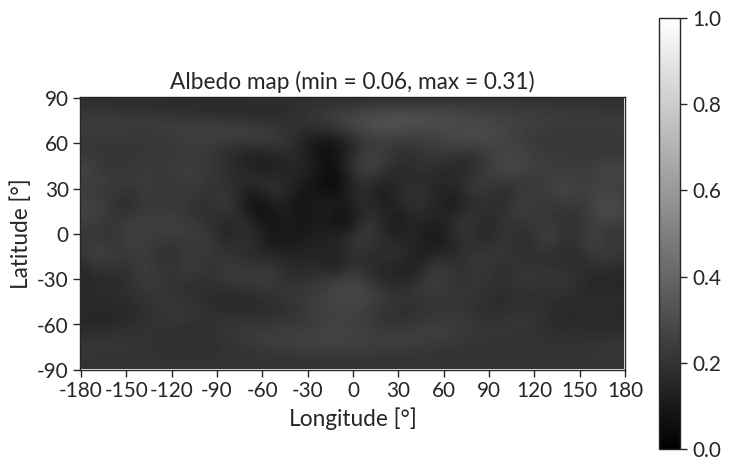

In [82]:
plot_albedo_map(albedo_map_shtools)

In [83]:
# from skimage import color, io, measure, img_as_ubyte, img_as_float

# im = albedo_map_shtools
# im = img_as_ubyte(color.gray2rgb(im))
# io.imsave("albedomap.png", im)
# io.imshow(im, cmap="gray")
# io.show()

In [84]:
f"RMS deviation of SF reconstructions: {normalized_root_mse(albedo_map_manual, albedo_map_shtools):.1%}"

'RMS deviation of SF reconstructions: 0.0%'

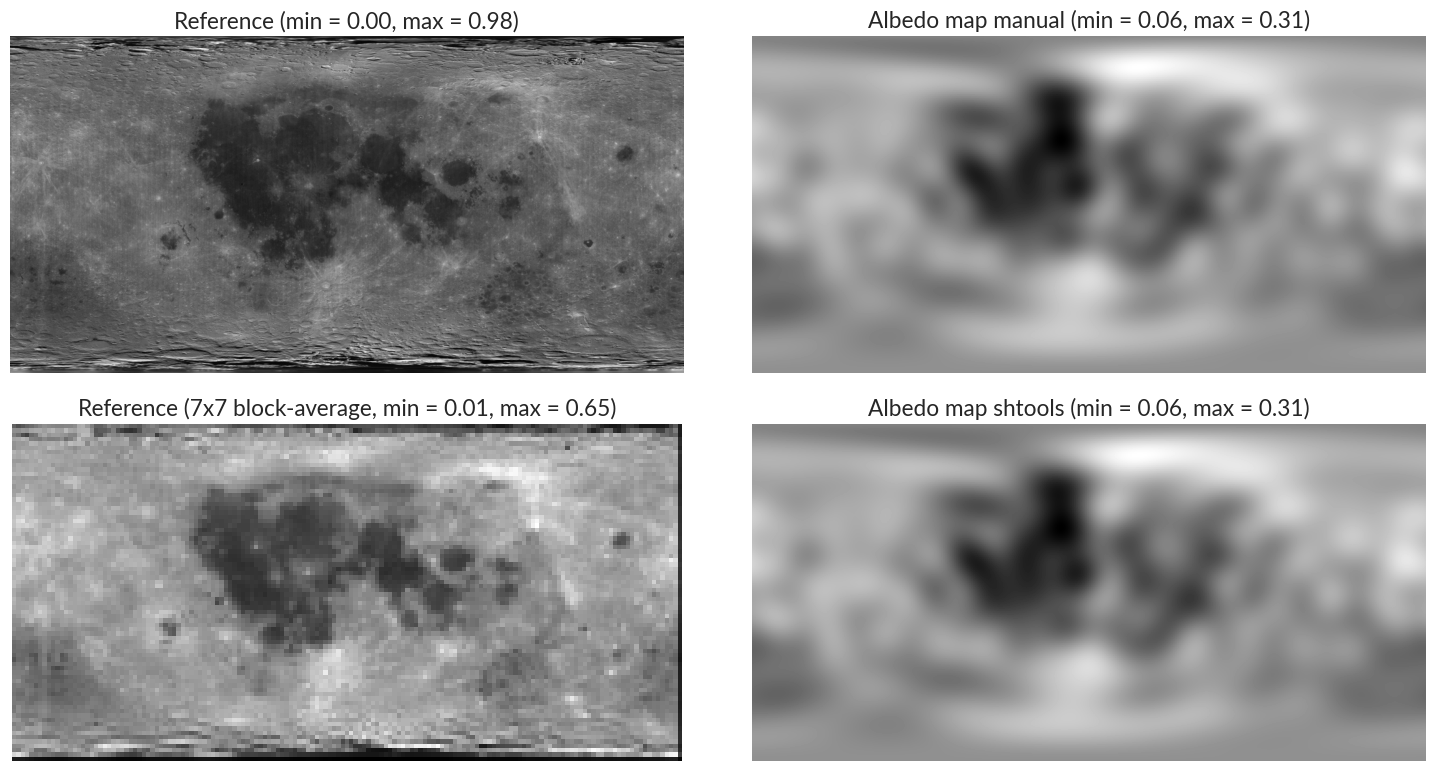

In [85]:
def plot_albedo_map_comparison(albedo_map_manual, albedo_map_shtools):
    ref = imread("files/albedo.tiff")
    # ref_blur = mean(ref, square(7))
    ref_blur = block_reduce(ref, 7, np.mean)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 8), tight_layout=True)

    ax1.imshow(ref, cmap="gray")
    ax1.axis("off")
    ax1.set_title(f"Reference (min = {ref.min()/255:.2f}, max = {ref.max()/255:.2f})")

    ax2.imshow(albedo_map_manual, cmap="gray")
    ax2.axis("off")
    ax2.set_title(f"Albedo map manual (min = {albedo_map_manual.min():.2f}, max = {albedo_map_manual.max():.2f})")

    ax3.imshow(ref_blur, cmap="gray")
    ax3.axis("off")
    ax3.set_title(f"Reference (7x7 block-average, min = {ref_blur.min()/255:.2f}, max = {ref_blur.max()/255:.2f})")

    ax4.imshow(albedo_map_shtools, cmap="gray")
    ax4.axis("off")
    ax4.set_title(f"Albedo map shtools (min = {albedo_map_shtools.min():.2f}, max = {albedo_map_shtools.max():.2f})")

plot_albedo_map_comparison(albedo_map_manual, albedo_map_shtools)

In [86]:
# albedo_map_manual.mean()
albedo_map_shtools.mean()

0.19971824049813106

In [87]:
def generate_initializer_list(coeffs):
    for row in range(coeffs.shape[0]):
        for col in range(coeffs.shape[1]):
            print(str(coeffs[row, col]) + ", ", end="")
        print()

# generate_initializer_list(cos_coeffs)
# generate_initializer_list(sin_coeffs)

## Unit test data for test_surfacePropertyDistributionSetup_SphericalHarmonics_DLAM1 in unitTestEnvironmentModelSetup

In [88]:
cos_coeffs[7, 6]

-5.2535643e-08

In [89]:
sin_coeffs[10, 3]

6.4835704e-06

In [90]:
with np.printoptions(precision=20):
    print(dlam1(0.7, 0.42, degrees=False))
    print(dlam1(-1.5, 0.9, degrees=False))

0.18141667202246156
0.2001460910686691
